In [367]:
import nibabel as nib
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter
`from scipy import ndimage
%matplotlib inline

In [336]:
def show_slices(slices):
    """ Function to display row of image slices """
    
    fig, axes = plt.subplots(1, len(slices),figsize = (15,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, origin="lower")

In [247]:
brain_mri_img_flair = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz')
brain_mri_img_t1 = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz')
brain_mri_img_t2= nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii.gz')
brain_mri_img_t1ce = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii.gz')
brain_mri_img_seg = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz')

brain_mri_img_flair_original_data = brain_mri_img_flair.get_fdata()
brain_mri_img_t1_original_data = brain_mri_img_t1.get_fdata()
brain_mri_img_t2_original_data = brain_mri_img_t2.get_fdata()
brain_mri_img_t1ce_original_data = brain_mri_img_t1ce.get_fdata()
brain_mri_img_seg_original_data = brain_mri_img_seg.get_fdata()

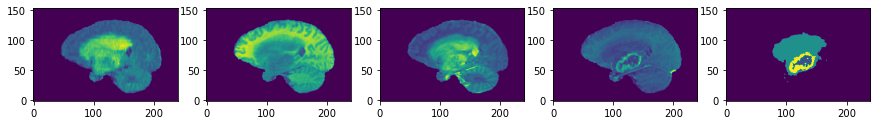

In [354]:
flair_original = brain_mri_img_flair_original_data[100,:,:]
t1_original = brain_mri_img_t1_original_data[100,:,:]
t2_orignal = brain_mri_img_t2_original_data[100,:,:]
t1ce_original = brain_mri_img_t1ce_original_data[100,:,:]
seg_img = brain_mri_img_seg_original_data[100,:,:]

slices_original = [flair_original,t1_original,t2_orignal,t1ce_original,seg_img]
show_slices(slices_original)

#### Random Flipping and Rotation

In [ ]:
def generate_permutation_keys():
    """
    This function returns a set of "keys" that represent the 48 unique rotations &
    reflections of a 3D matrix.
    Each item of the set is a tuple:
    ((rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose)
    As an example, ((0, 1), 0, 1, 0, 1) represents a permutation in which the data is
    rotated 90 degrees around the z-axis, then reversed on the y-axis, and then
    transposed.
    48 unique rotations & reflections:
    https://en.wikipedia.org/wiki/Octahedral_symmetry#The_isometries_of_the_cube
    """
    return set(itertools.product(
        itertools.combinations_with_replacement(range(2), 2), range(2), range(2), range(2), range(2)))


def random_permutation_key():
    """
    Generates and randomly selects a permutation key. See the documentation for the
    "generate_permutation_keys" function.
    """
    return random.choice(list(generate_permutation_keys()))


def permute_data(data, key):
    """
    Permutes the given data according to the specification of the given key. Input data
    must be of shape (n_modalities, x, y, z).
    Input key is a tuple: (rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose)
    As an example, ((0, 1), 0, 1, 0, 1) represents a permutation in which the data is
    rotated 90 degrees around the z-axis, then reversed on the y-axis, and then
    transposed.
    """
    data = np.copy(data)
    (rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose = key

    if rotate_y != 0:
        data = np.rot90(data, rotate_y, axes=(0, 2))
    if rotate_z != 0:
        data = np.rot90(data, rotate_z, axes=(1, 2))
    if flip_x:
        data = data[::-1]
    if flip_y:
        data = data[:, ::-1]
    if flip_z:
        data = data[:, :, ::-1]
    if transpose:
        for i in range(data.shape[0]):
            data[i] = data[i].T
    return data


def random_permutation(data):
    """
    Performs random permutation on the data.
    :param x_data: numpy array containing the data. Data must be of shape (n_modalities, x, y, z).
    :param y_data: numpy array containing the data. Data must be of shape (n_modalities, x, y, z).
    :return: the permuted data
    """
    return permute_data(data, key)

# source: https://github.com/akhanss/BraTS-2020/blob/master/src/unet3d/augment.py

In [318]:
key = random_permutation_key() # generates random combination of rotation and flipping along x,y,z axes

brain_mri_img_flair_flip_rotate = random_permutation(brain_mri_img_flair_original_data)
brain_mri_img_t1_flip_rotate = random_permutation(brain_mri_img_t1_original_data)
brain_mri_img_t2_flip_rotate = random_permutation(brain_mri_img_t2_original_data)
brain_mri_img_t1ce_flip_rotate = random_permutation(brain_mri_img_t1ce_original_data)
brain_mri_img_seg_flip_rotate = random_permutation(brain_mri_img_seg_original_data)

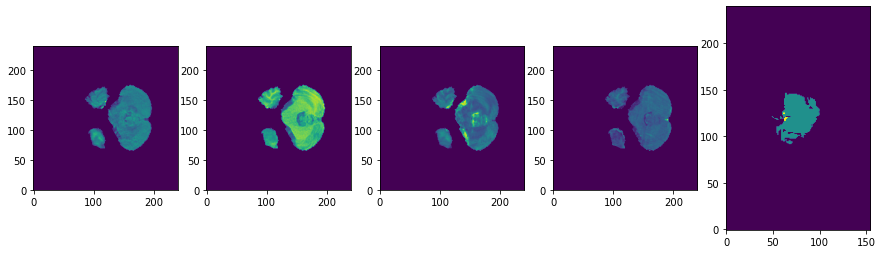

In [358]:
# display a slice of augmented data(flip + rotation)

flair_flip_rotate = brain_mri_img_flair_flip_rotate[120,:,:]
t1_flip_rotate = brain_mri_img_t1_flip_rotate[120,:,:]
t2_flip_rotate = brain_mri_img_t2_flip_rotate[120,:,:]
t1ce_flip_rotate = brain_mri_img_t1ce_flip_rotate[120,:,:]
seg_img_flip_rotate = brain_mri_img_seg_original_data_flip_rotate[120,:,:]

slices_flip_rotate = [flair_flip_rotate,t1_flip_rotate,t2_flip_rotate,t1ce_flip_rotate,seg_img_flip_rotate]
show_slices(slices_flip_rotate)

#### Rescale and Crop

In [59]:
def scaleit(image, factor, isseg=False):
    order = 0 if isseg == True else 3

    height, width, depth= image.shape
    zheight             = int(np.round(factor * height))
    zwidth              = int(np.round(factor * width))
    zdepth              = depth

    if factor < 1.0:
        newimg  = np.zeros_like(image)
        row     = (height - zheight) // 2
        col     = (width - zwidth) // 2
        layer   = (depth - zdepth) // 2
        newimg[row:row+zheight, col:col+zwidth, layer:layer+zdepth] = zoom(image, (float(factor), float(factor), 1.0), order=order, mode='nearest')[0:zheight, 0:zwidth, 0:zdepth]

        return newimg

    elif factor > 1.0:
        row     = (zheight - height) // 2
        col     = (zwidth - width) // 2
        layer   = (zdepth - depth) // 2

        newimg = zoom(image[row:row+zheight, col:col+zwidth, layer:layer+zdepth], (float(factor), float(factor), 1.0), order=order, mode='nearest')  
        
        extrah = (newimg.shape[0] - height) // 2
        extraw = (newimg.shape[1] - width) // 2
        extrad = (newimg.shape[2] - depth) // 2
        newimg = newimg[extrah:extrah+height, extraw:extraw+width, extrad:extrad+depth]

        return newimg

    else:
        return image
    
# source: https://mlnotebook.github.io/post/dataaug/

In [350]:
factor_1 = .80 # factor for down scaling, will be replaced with randomized sampling

brain_mri_img_flair_rescale_crop = scaleit(brain_mri_img_flair_original_data, factor_1)
brain_mri_img_t1_rescale_crop = scaleit(brain_mri_img_t1_original_data, factor_1)
brain_mri_img_t2_rescale_crop = scaleit(brain_mri_img_t2_original_data, factor_1)
brain_mri_img_t1ce_rescale_crop = scaleit(brain_mri_img_t1ce_original_data, factor_1)
brain_mri_img_seg_rescale_crop = scaleit(brain_mri_img_seg_original_data, factor_1)

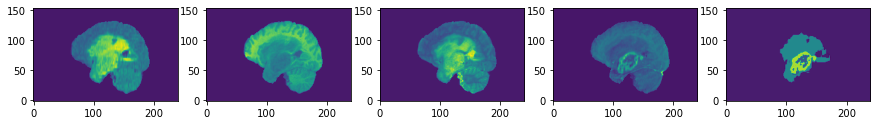

In [405]:
# display a slice of augmented data(downscaled)

flair_rescale_crop = brain_mri_img_flair_rescale_crop[100,:,:]
t1_rescale_crop = brain_mri_img_t1_rescale_crop[100,:,:]
t2_rescale_crop = brain_mri_img_t2_rescale_crop[100,:,:]
t1ce_rescale_crop = brain_mri_img_t1ce_rescale_crop[100,:,:]
seg_img_rescale_crop = brain_mri_img_seg_rescale_crop[100,:,:]

slices_rescale_crop_downscaled = [flair_rescale_crop, t1_rescale_crop, t2_rescale_crop, t1ce_rescale_crop, seg_img_rescale_crop]
show_slices(slices_rescale_crop_downscaled)

In [332]:
factor_2 = 1.25 # factor for upscaling, will be replaced with randomized sampling

brain_mri_img_flair_rescale_crop_upscaled = scaleit(brain_mri_img_flair_original_data, factor_2)
brain_mri_img_t1_rescale_crop_upscaled = scaleit(brain_mri_img_t1_original_data, factor_2)
brain_mri_img_t2_rescale_crop_upscaled = scaleit(brain_mri_img_t2_original_data, factor_2)
brain_mri_img_t1ce_rescale_crop_upscaled = scaleit(brain_mri_img_t1ce_original_data, factor_2)
brain_mri_img_seg_rescale_crop_upscaled = scaleit(brain_mri_img_seg_original_data, factor_2)

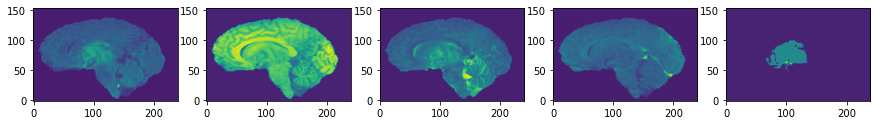

In [404]:
# display a slice of augmented data(upscaled)

flair_rescale_crop_upscaled = brain_mri_img_flair_rescale_crop_upscaled[100,:,:]
t1_rescale_crop_upscaled = brain_mri_img_t1_rescale_crop_upscaled[100,:,:]
t2_rescale_crop_upscaled = brain_mri_img_t2_rescale_crop_upscaled[100,:,:]
t1ce_rescale_crop_upscaled = brain_mri_img_t1ce_rescale_crop_upscaled[100,:,:]
seg_img_rescale_crop_upscaled = brain_mri_img_seg_rescale_crop_upscaled[100,:,:]

slices_rescale_crop_upscaled = [flair_rescale_crop_upscaled, t1_rescale_crop_upscaled, t2_rescale_crop_upscaled, t1ce_rescale_crop_upscaled, seg_img_rescale_crop_upscaled]
show_slices(slices_rescale_crop_upscaled)

#### Gaussian Filter


In [ ]:
# using gaussian filter function from SciPy library 

In [365]:
brain_mri_img_flair_gaussian_filter = gaussian_filter(brain_mri_img_flair_original_data, 2, mode= 'nearest')
brain_mri_img_t1_gaussian_filter = gaussian_filter(brain_mri_img_t1_original_data, 2, mode= 'nearest')
brain_mri_img_t2_gaussian_filter = gaussian_filter(brain_mri_img_t2_original_data, 2, mode= 'nearest')
brain_mri_img_t1ce_gaussian_filter = gaussian_filter(brain_mri_img_t1ce_original_data, 2, mode= 'nearest')
brain_mri_img_seg_gaussian_filter = gaussian_filter(brain_mri_img_seg_original_data, 2, mode= 'nearest')

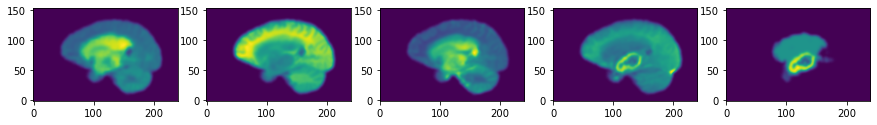

In [366]:
# display a slice of augmented data(gaussian blur)

flair_gaussian_filter = brain_mri_img_flair_gaussian_filter[100,:,:]
t1_gaussian_filter = brain_mri_img_t1_gaussian_filter[100,:,:]
t2_gaussian_filter = brain_mri_img_t2_gaussian_filter[100,:,:]
t1ce_gaussian_filter = brain_mri_img_t1ce_gaussian_filter[100,:,:]
seg_img_gaussian_filter = brain_mri_img_seg_gaussian_filter[100,:,:]

slices_gaussian_filter = [flair_gaussian_filter, t1_gaussian_filter, t2_gaussian_filter, t1ce_gaussian_filter, seg_img_gaussian_filter]
show_slices(slices_gaussian_filter)

#### Sharpening

In [ ]:
# using gaussian filter function from SciPy library 

In [368]:
    def sharpen(data):

        blurred_f = ndimage.gaussian_filter(data, 3)

        filter_blurred_f = ndimage.gaussian_filter(data, 1)

        alpha = 1.5
        sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

        return sharpened

In [369]:
# display a slice of augmented data(sharpen)

brain_mri_img_flair_sharpen = sharpen(brain_mri_img_flair_original_data)
brain_mri_img_t1_sharpen = sharpen(brain_mri_img_t1_original_data)
brain_mri_img_t2_sharpen = sharpen(brain_mri_img_t2_original_data)
brain_mri_img_t1ce_sharpen = sharpen(brain_mri_img_t1ce_original_data)
brain_mri_img_seg_sharpen = sharpen(brain_mri_img_seg_original_data)

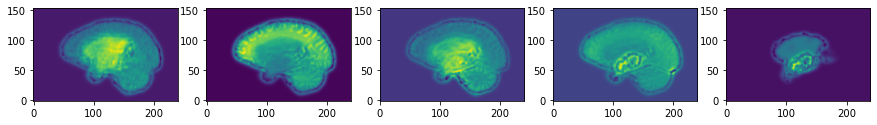

In [370]:
flair_sharpen= brain_mri_img_flair_sharpen[100,:,:]
t1_sharpen = brain_mri_img_t1_sharpen[100,:,:]
t2_sharpen = brain_mri_img_t2_sharpen[100,:,:]
t1ce_sharpen = brain_mri_img_t1ce_sharpen[100,:,:]
seg_img_sharpen = brain_mri_img_seg_sharpen[100,:,:]

slices_sharpen = [flair_sharpen, t1_sharpen, t2_sharpen, t1ce_sharpen, seg_img_sharpen]
show_slices(slices_sharpen)

### FOUR MODALITIES WITH APPLICATION OF DIFFERENT AUGMENTED DATA METHODS

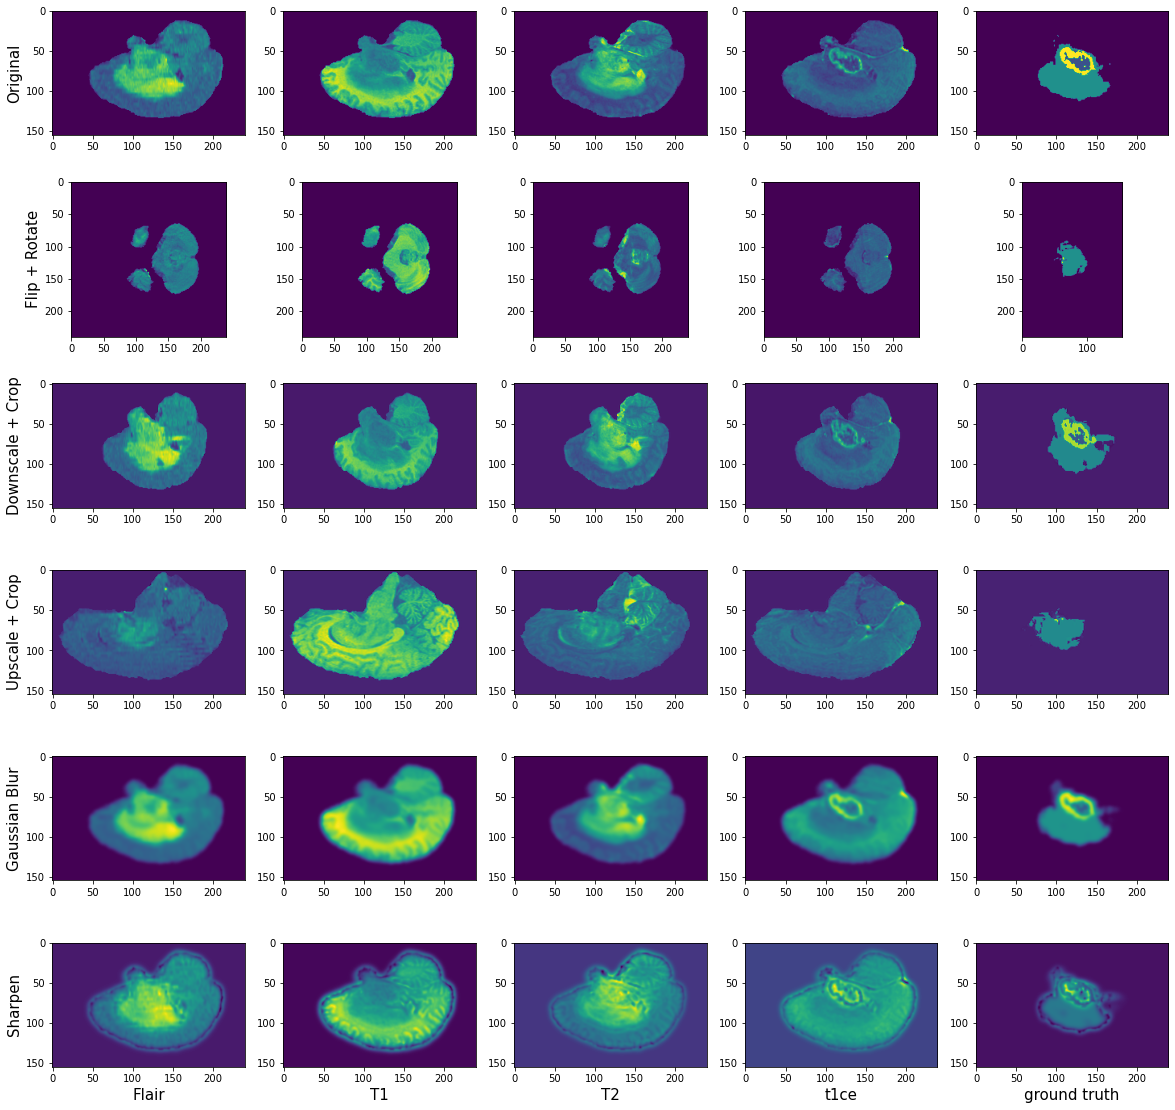

In [473]:
fig, axs = plt.subplots(6,5, figsize = (20,20))
# fig.tight_layout() 
for i in range(len(slices_original)):  
    axs[0,i].imshow(slices_original[i].T)
axs[0,0].set_ylabel("Original", fontsize = 15)

for i in range(len(slices_flip_rotate)):
    axs[1,i].imshow(slices_flip_rotate[i].T)
axs[1,0].set_ylabel("Flip + Rotate", fontsize = 15)
    
for i in range(len(slices_rescale_crop_downscaled)):
    axs[2,i].imshow(slices_rescale_crop_downscaled[i].T)
axs[2,0].set_ylabel("Downscale + Crop", fontsize = 15)
    
for i in range(len(slices_rescale_crop_upscaled)):
    axs[3,i].imshow(slices_rescale_crop_upscaled[i].T)
axs[3,0].set_ylabel("Upscale + Crop", fontsize = 15)
    
for i in range(len(slices_gaussian_filter)):
    axs[4,i].imshow(slices_gaussian_filter[i].T)
axs[4,0].set_ylabel("Gaussian Blur", fontsize = 15)
    
for i in range(len(slices_sharpen)):
    axs[5,i].imshow(slices_sharpen[i].T)
axs[5,0].set_ylabel("Sharpen", fontsize = 15)


axs[5,0].set_xlabel("Flair", fontsize = 15)
axs[5,1].set_xlabel("T1", fontsize = 15)
axs[5,2].set_xlabel("T2", fontsize = 15)
axs[5,3].set_xlabel("t1ce", fontsize = 15)
axs[5,4].set_xlabel("ground truth", fontsize = 15)


plt.savefig('plot_2.png')